# Libs

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax, grid_search_sarimax

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from skopt import BayesSearchCV

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
np.int = np.int_


Model_name = {}
Model_mae = {}

# Read data

In [117]:
data = pd.read_csv('data.csv', sep=';')
data = data.drop(['Date','Type2','Type3'], axis=1)
data['Date']=pd.to_datetime(data['Date2'],format="%d.%m.%Y", errors='coerce')
data = data.drop('Date2', axis=1)

# Week days
data['weekDay']=data['Date'].dt.dayofweek
# Day
data['Day']=data['Date'].dt.day
# Month
data['Month']=data['Date'].dt.month
# Year
data['Year']=data['Date'].dt.year

In [118]:
print(data.head())

   Sample  Type       Date  weekDay  Day  Month  Year
0  611222     1 2018-08-16        3   16      8  2018
1  611223     1 2018-08-16        3   16      8  2018
2  611224     1 2018-08-16        3   16      8  2018
3  611226     3 2018-08-16        3   16      8  2018
4  611227     3 2018-08-16        3   16      8  2018


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107022 entries, 0 to 107021
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Sample   107022 non-null  int64         
 1   Type     107022 non-null  int64         
 2   Date     107022 non-null  datetime64[ns]
 3   weekDay  107022 non-null  int32         
 4   Day      107022 non-null  int32         
 5   Month    107022 non-null  int32         
 6   Year     107022 non-null  int32         
dtypes: datetime64[ns](1), int32(4), int64(2)
memory usage: 4.1 MB


# Vizualisations

#### Daily

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


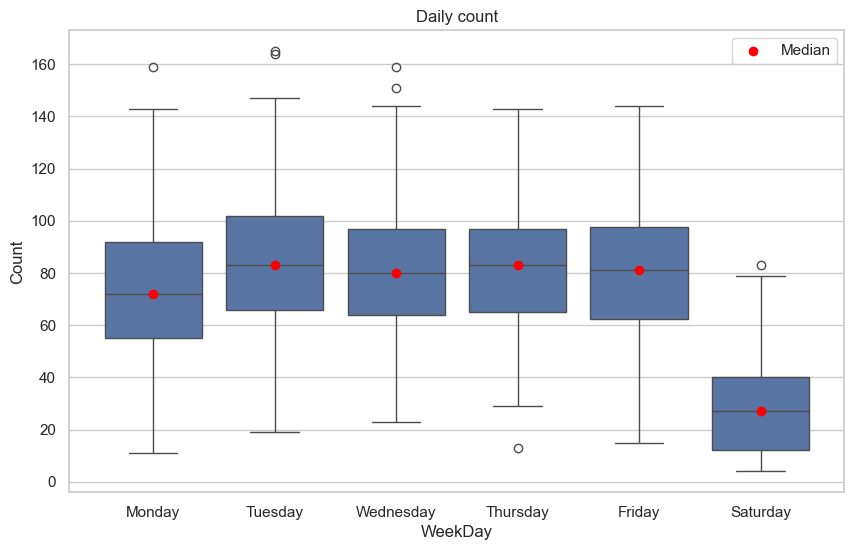

In [120]:
df_week=data[['Sample', 'Date', 'weekDay']]
df_week['WeekDay']=df_week['weekDay'].replace([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

df_week = df_week.groupby(['Date', 'WeekDay', 'weekDay'])['Sample'].count().reset_index()
df_week.columns = ['Date', 'WeekDay', 'weekDay', 'Count']

# Create a boxplot using matplotlib
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.boxplot(x='WeekDay', y='Count', data=df_week, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Daily count')
plt.ylabel('Count')

# Create a scatterplot using matplotlib
median_values = df_week.groupby(['WeekDay'])['Count'].median()
plt.scatter(median_values.index, median_values.values, color='red', marker='o', label='Median', zorder=5)

# Show legend and plot
plt.legend()
plt.show()

#### Monthly

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


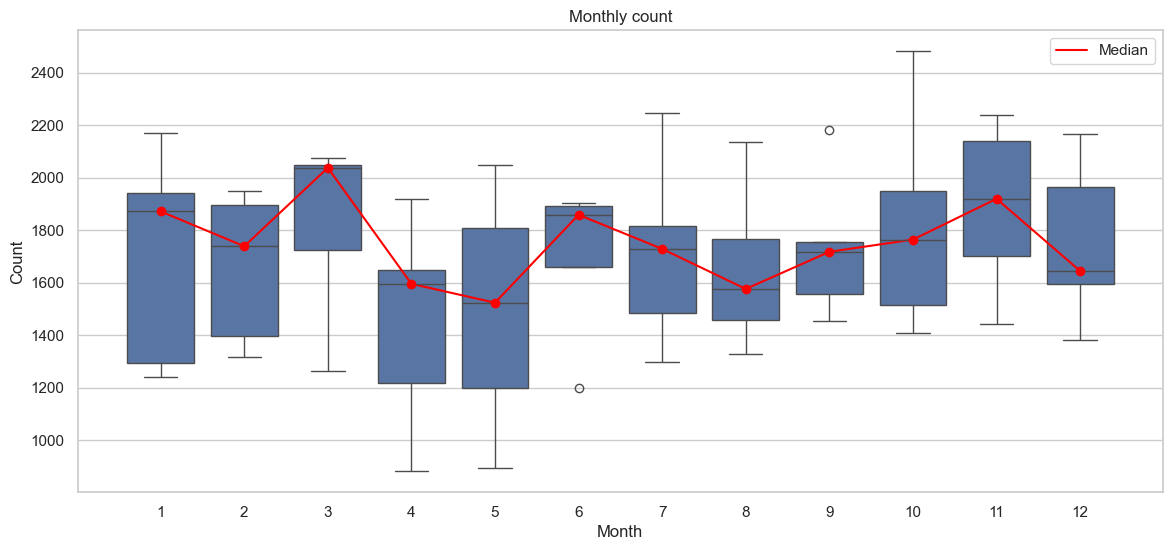

In [121]:
df_month = data.copy()
df_month['Month'] = data['Date'].dt.month
df_month['Year'] = data['Date'].dt.year
df_month = df_month.groupby(['Month', 'Year'])['Sample'].count().reset_index()
df_month.columns = ['Month', 'Year', 'Count']

plt.figure(figsize=(14, 6))
sns.boxplot(x='Month', y='Count', data=df_month, order=range(1, 13))
plt.title('Monthly count')
plt.ylabel('Count')

# Create a lineplot using matplotlib
median_values = df_month.groupby(['Month'])['Count'].median()
plt.plot(median_values.index-1, median_values.values, label='Median', color='red')

# Create a scatterplot using matplotlib
plt.scatter(median_values.index-1, median_values.values, color='red', marker='o', zorder=5)

# Show legend and plot
plt.legend()
plt.show()

#### Yearly

In [122]:
df_year = data.copy()
df_year['Year'] = df_year['Date'].dt.year
df_year = pd.DataFrame(df_year['Year'].value_counts())
df_year = df_year.reset_index()
df_year.columns = ['Year', 'Count']

fig = px.bar(df_year, x='Year', y='Count', title='Count by year')
fig.show()

#### By Type

In [123]:
df_prod=pd.DataFrame(data['Type'].value_counts())
df_prod= df_prod.reset_index()
df_prod.columns = ['Type', 'Count']
fig = px.bar(df_prod, x='Type', y='Count', title='Count by type')
fig.show()

# Data preparation

In [124]:
df = data[data['Type'] == 1]
df.shape

(60781, 7)

In [125]:
df['Day'] = df['Date'].dt.day
df = df.groupby(by=['Date', 'weekDay', 'Day', 'Month', 'Year']).count().reset_index()
df = df.drop(['Type'], axis=1)
df = df.rename(columns={"Sample": "Count"})
df = df.set_index('Date')
df = df.asfreq('1D')

df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max()))
df = df.sort_index()
df.head(10)

,weekDay,Day,Month,Year,Count
2018-08-07,1.0,7.0,8.0,2018.0,19.0
2018-08-08,2.0,8.0,8.0,2018.0,79.0
2018-08-09,3.0,9.0,8.0,2018.0,71.0
2018-08-10,4.0,10.0,8.0,2018.0,65.0
2018-08-11,NaN,NaN,NaN,NaN,NaN
2018-08-12,NaN,NaN,NaN,NaN,NaN
2018-08-13,0.0,13.0,8.0,2018.0,56.0
2018-08-14,1.0,14.0,8.0,2018.0,43.0
2018-08-15,2.0,15.0,8.0,2018.0,91.0
2018-08-16,3.0,16.0,8.0,2018.0,32.0


In [126]:
df['weekDay'] = df.index.dayofweek
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Count'] = df['Count'].fillna(0)
# df['Count'].fillna(method='ffill', inplace=True)
df.head(10)

,weekDay,Day,Month,Year,Count
2018-08-07,1,7,8,2018,19.0
2018-08-08,2,8,8,2018,79.0
2018-08-09,3,9,8,2018,71.0
2018-08-10,4,10,8,2018,65.0
2018-08-11,5,11,8,2018,0.0
2018-08-12,6,12,8,2018,0.0
2018-08-13,0,13,8,2018,56.0
2018-08-14,1,14,8,2018,43.0
2018-08-15,2,15,8,2018,91.0
2018-08-16,3,16,8,2018,32.0


In [127]:
end_train = '2023-07-03'

data_train = df.loc[: end_train, :]
data_val  = df.loc[end_train:, :]

print(f"Training dates   : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")

Training dates   : 2018-08-07 00:00:00 --- 2023-07-03 00:00:00  (n=1792)
Validation dates : 2023-07-03 00:00:00 --- 2023-10-25 00:00:00  (n=115)


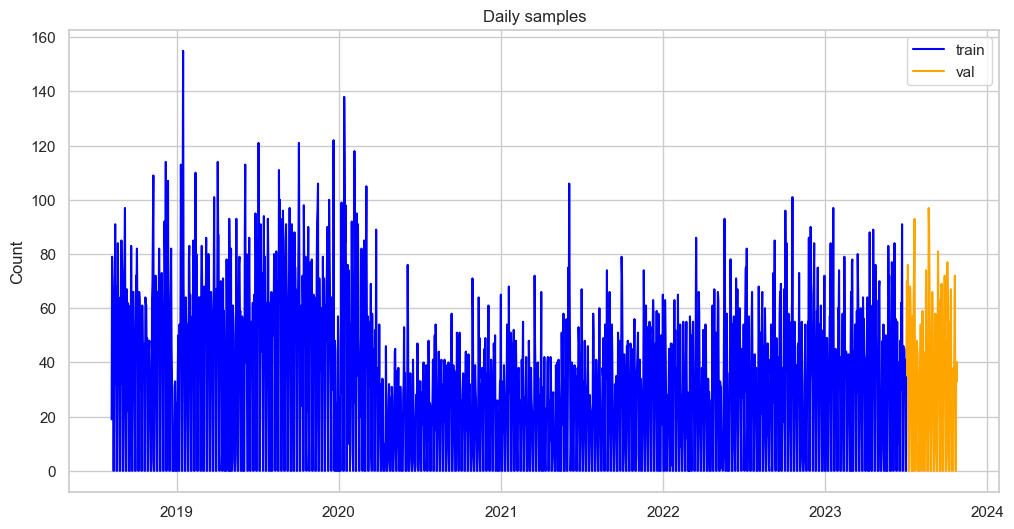

In [128]:
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(data_train['Count'], label='train', color='blue')

# Plot validation data
plt.plot(data_val['Count'], label='val', color='orange')

# Set plot title and labels
plt.title('Daily samples')
plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()

#### Seasonal decomposition

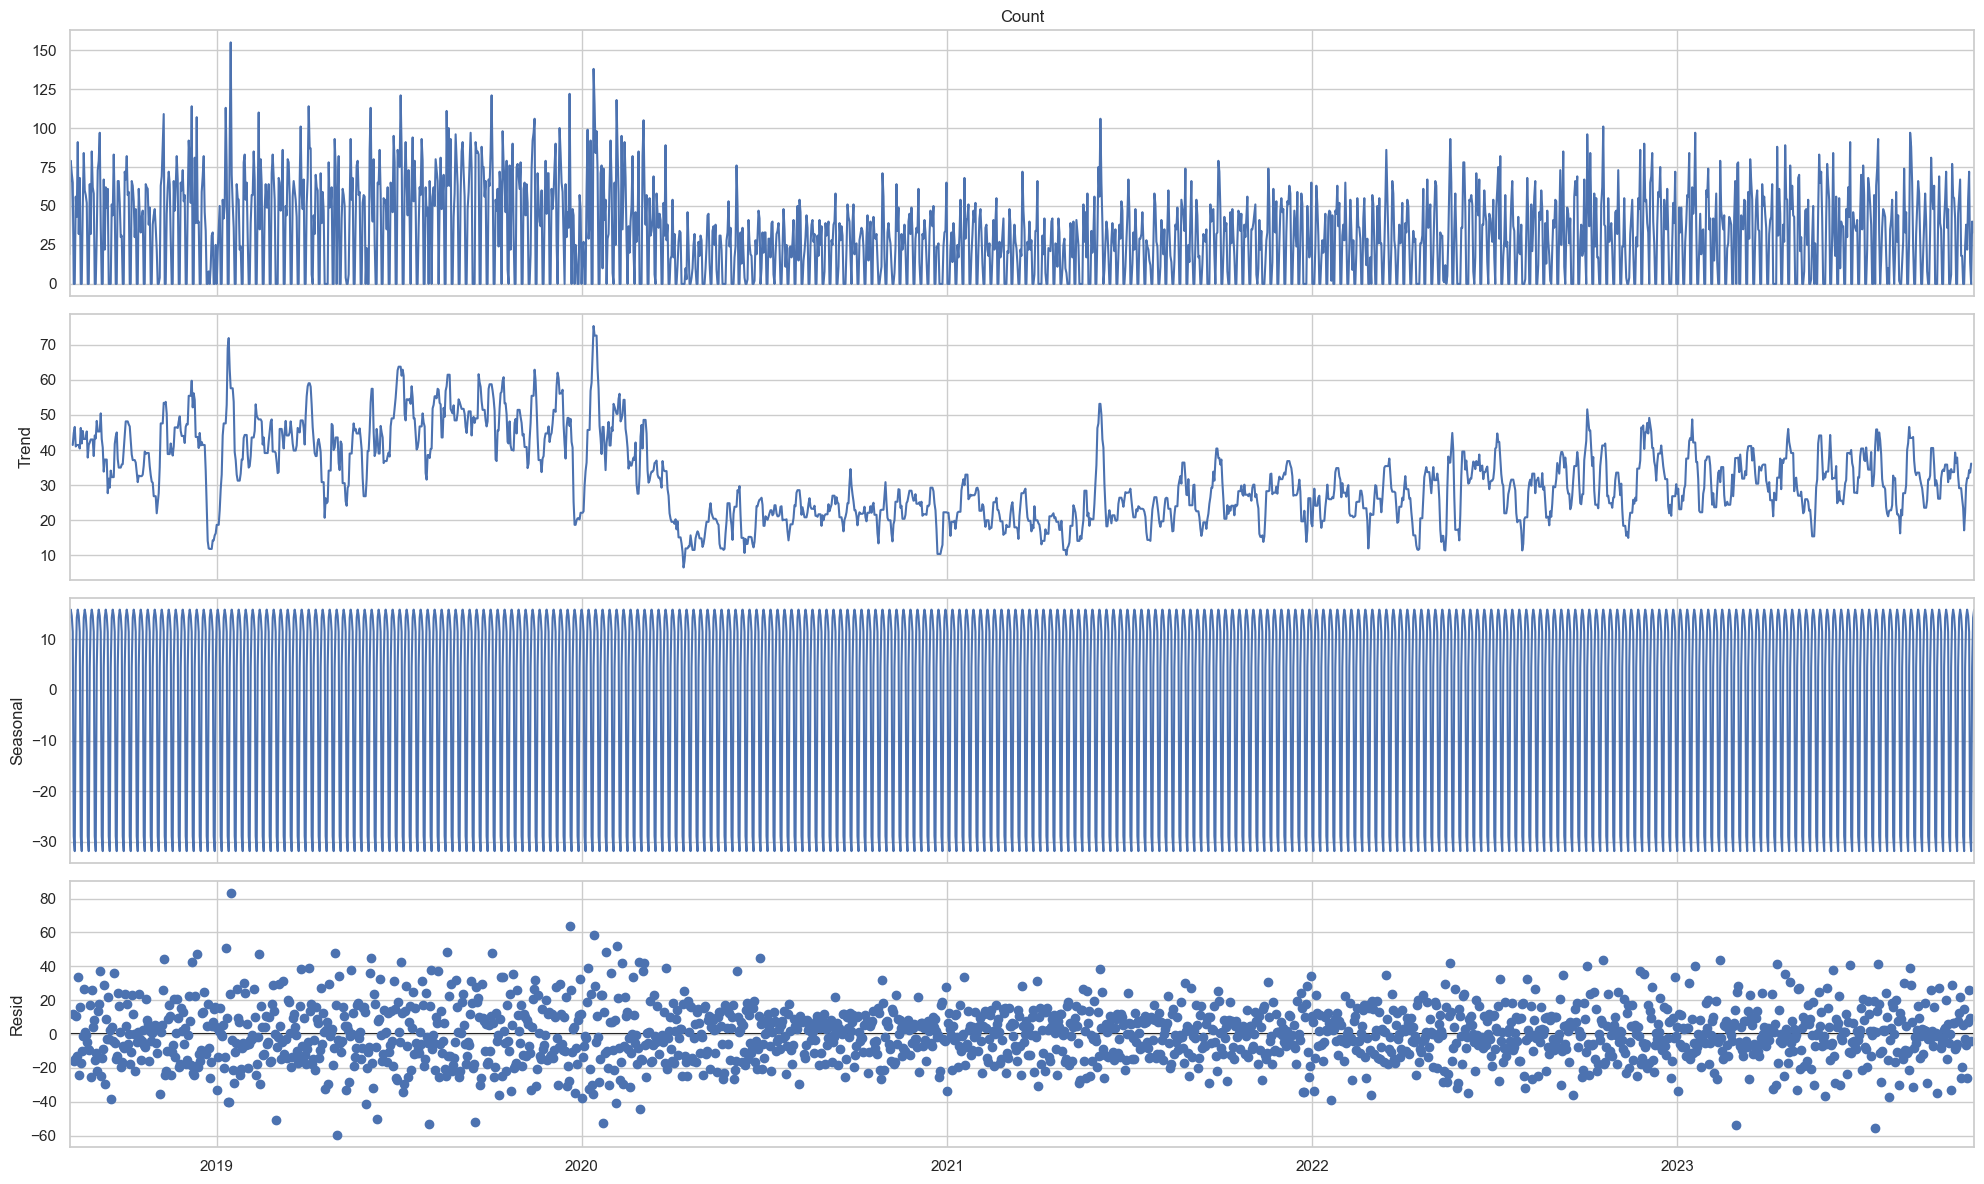

In [129]:
result = seasonal_decompose(x=df.Count,
                            model='additive', #model : {"additive", "multiplicative"}
                            period=7)
fig = result.plot()
plt.rcParams['figure.figsize'] = [20,12]

#### Stationarity control

In [130]:
fuller = adfuller(df.Count)
print('ADF Statistic: %f' % fuller[0])
print('p-value: %f' % fuller[1])
print('Critical Values:')
for key, value in fuller[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.944128
p-value: 0.001733
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


>p-value <0.05 ->time series is stationary

#### Autocorrelation

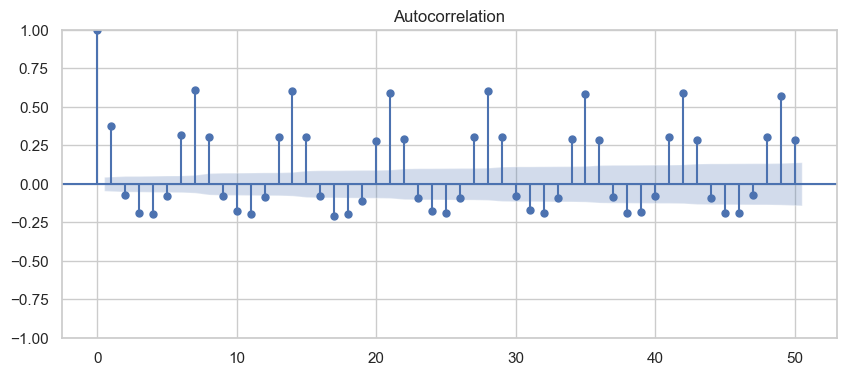

In [131]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df.Count, ax=ax, lags=50)
plt.show()

#### Partial autocorrelation

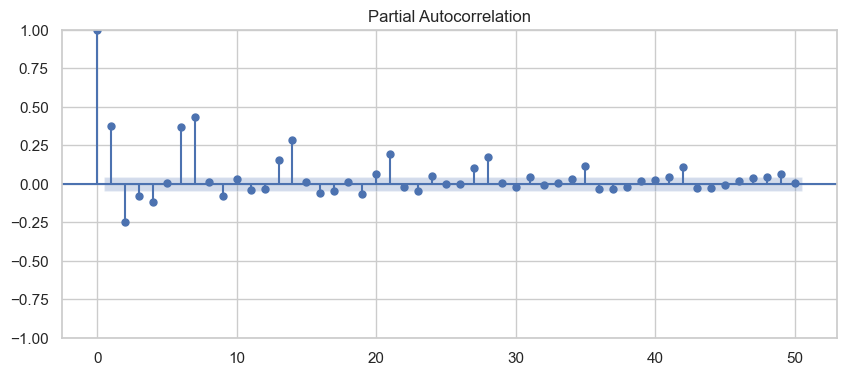

In [132]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df.Count, ax=ax, lags=50);
plt.show();

### Baseline

In [133]:
Targets = data_val['Count']
baseline_prediction = data_val['Count'].shift(1)
baseline_prediction = baseline_prediction.dropna()
Targets = Targets.loc[baseline_prediction.index]


mae_baseline = mean_absolute_error(Targets, baseline_prediction)
print(f'Baseline MAE: {mae_baseline:.2f}')

Model_mae['Baseline']=mae_baseline

Baseline MAE: 22.99


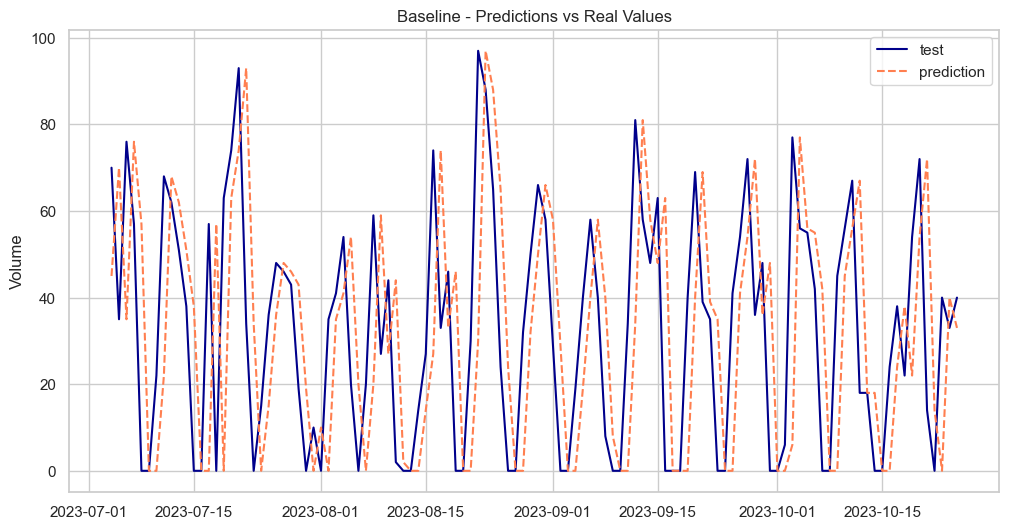

In [134]:
# plot predictions vs expected
plt.figure(figsize=(12, 6))
plt.plot(Targets, label='test', color='darkblue')
plt.plot(baseline_prediction, label='prediction', color='coral', linestyle='dashed')
plt.title('Baseline - Predictions vs Real Values')
plt.ylabel('Volume')
plt.legend(loc='upper right')

# Show the plot
plt.show()

#### ARIMA

In [135]:
# p=7 (7 lags) / d=1 / q=2 (moving average size)
order = (7, 0, 0)
model = ARIMA(data_train['Count'], order=(7, 0, 0))
fit_model = model.fit()
predictions = fit_model.predict(start=len(data_train), end=len(data_train) + len(data_val) - 1, typ='levels')

In [136]:
arima_mae = mean_absolute_error(data_val['Count'], predictions)
print(f'ARIMA mean absolute error (MAE): {arima_mae:.2f}')

ARIMA mean absolute error (MAE): 22.84


Fine tune

In [137]:
# Define a range of values for p, d, and q
p_values = range(1, 5)
d_values = range(0, 3)
q_values = range(3, 14)

best_mae = float('inf')
best_order = None

# Grid search over different values of p, d, and q
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            
            # Skip orders that are not valid for ARIMA
            if d == 0 and p == 0:
                continue
            
            try:
                model = ARIMA(data_train['Count'], order=order)
                fit_model = model.fit()
                predictions = fit_model.predict(start=len(data_train), end=len(data_train) + len(data_val) - 1, typ='levels')
                mae = mean_absolute_error(data_val['Count'], predictions)

                if mae < best_mae:
                    best_mae = mae
                    best_order = order
                    print(f'Order: {order}, MAE: {mae:.2f}')


            except Exception as e:
                # Handle exceptions for invalid parameter combinations
                print(f'Error for order {order}: {e}')

print(f'Best Order: {best_order}, Best MAE: {best_mae}')

Model_mae['Arima']=best_mae

Order: (1, 0, 3), MAE: 22.77
Order: (1, 0, 7), MAE: 22.72
Order: (2, 0, 3), MAE: 20.68
Order: (2, 0, 6), MAE: 20.48
Order: (2, 0, 8), MAE: 20.39
Order: (3, 0, 3), MAE: 19.78
Best Order: (3, 0, 3), Best MAE: 19.776684699516068


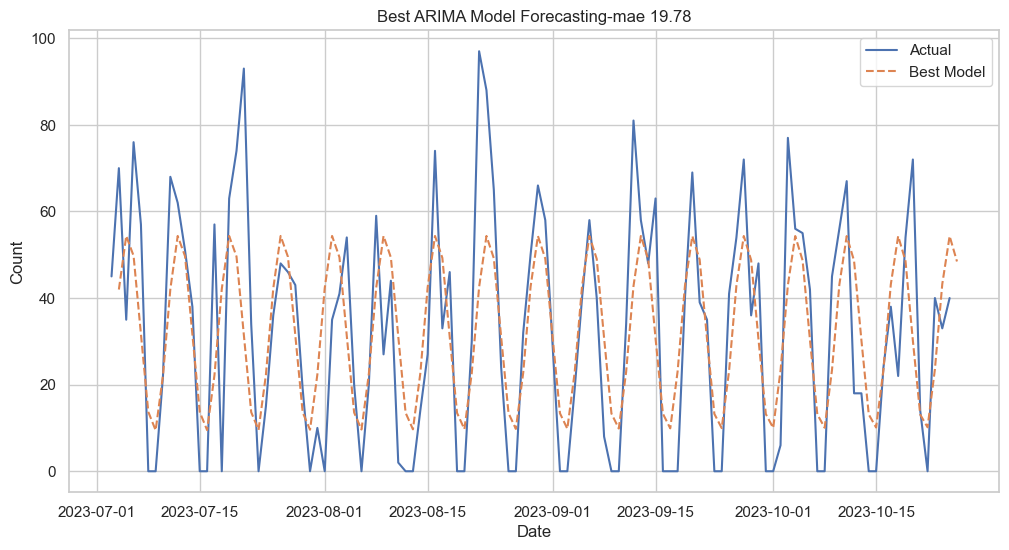

In [138]:
best_model = ARIMA(data_train['Count'], order=best_order)
best_fit_model = best_model.fit()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data_val['Count'], label='Actual')
plt.plot(best_fit_model.predict(start=len(data_train), end=len(data_train) + len(data_val) - 1, typ='levels'), 
         label='Best Model', linestyle='dashed')
plt.title(f'Best ARIMA Model Forecasting-mae {best_mae:.2f}')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

### Random Forest

Data preparation

In [139]:
data_train.head(8)

,weekDay,Day,Month,Year,Count
2018-08-07,1,7,8,2018,19.0
2018-08-08,2,8,8,2018,79.0
2018-08-09,3,9,8,2018,71.0
2018-08-10,4,10,8,2018,65.0
2018-08-11,5,11,8,2018,0.0
2018-08-12,6,12,8,2018,0.0
2018-08-13,0,13,8,2018,56.0
2018-08-14,1,14,8,2018,43.0


In [140]:
def create_lag_features(df, lag):
    df_1 = df.copy()
    for i in range(1, lag + 1):
        df_1[f'lag_{i}'] = df['Count'].shift(i)
    return df_1.dropna()

lag_order = 7

In [141]:
train_lagged = create_lag_features(data_train, lag_order)
val_lagged = create_lag_features(data_val, lag_order)
train_lagged.head(8)

,weekDay,Day,Month,Year,Count,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
2018-08-14,1,14,8,2018,43.0,56.0,0.0,0.0,65.0,71.0,79.0,19.0
2018-08-15,2,15,8,2018,91.0,43.0,56.0,0.0,0.0,65.0,71.0,79.0
2018-08-16,3,16,8,2018,32.0,91.0,43.0,56.0,0.0,0.0,65.0,71.0
2018-08-17,4,17,8,2018,68.0,32.0,91.0,43.0,56.0,0.0,0.0,65.0
2018-08-18,5,18,8,2018,0.0,68.0,32.0,91.0,43.0,56.0,0.0,0.0
2018-08-19,6,19,8,2018,0.0,0.0,68.0,32.0,91.0,43.0,56.0,0.0
2018-08-20,0,20,8,2018,49.0,0.0,0.0,68.0,32.0,91.0,43.0,56.0
2018-08-21,1,21,8,2018,84.0,49.0,0.0,0.0,68.0,32.0,91.0,43.0


Modelization

In [142]:
X_train = train_lagged.drop('Count', axis=1)
Y_train = train_lagged['Count']
X_val = val_lagged.drop('Count', axis=1)
Y_val = val_lagged['Count']

# Initialize and fit the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, criterion='absolute_error',random_state=42)
rf_model.fit(X_train, Y_train)

predictions = rf_model.predict(X_val)

# Evaluate the model
RF_mae = mean_absolute_error(Y_val, predictions)
print(f'Random forest mean absolute error (MAE): {RF_mae:.2f}')

Random forest mean absolute error (MAE): 13.37


Fine tuning

In [143]:
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200, 250],
    'max_depth': [None, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

rf_model = RandomForestRegressor(criterion='absolute_error',random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1, verbose=2)

grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.8s
[CV] END max_dep

Random Forest Mean Absolute Error (MAE): 12.98


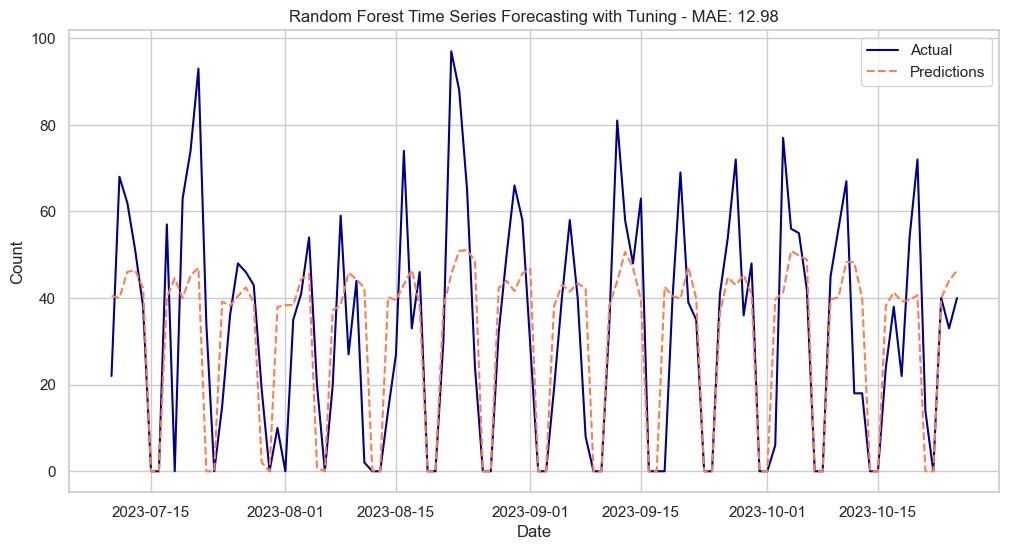

In [144]:
# Make predictions with the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_val)

# Evaluate the model
RF_mae = mean_absolute_error(Y_val, predictions)
print(f'Random Forest Mean Absolute Error (MAE): {RF_mae:.2f}')

Model_mae['Random Forest']=RF_mae

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(Y_val.index, Y_val, label='Actual', color='darkblue')
# Ensure that the lengths and indices match
plt.plot(Y_val.index[:len(predictions)], predictions, label='Predictions', linestyle='dashed', color='coral')
plt.title(f'Random Forest Time Series Forecasting with Tuning - MAE: {RF_mae:.2f}')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

### Gradient boosting model

In [145]:
data_train['weekDay'] = data_train['weekDay'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                                                      [0, 1, 2, 3, 4, 5, 6])
data_val['weekDay'] = data_val['weekDay'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                                                  [0, 1, 2, 3, 4, 5, 6])

X_train = data_train[['Day', 'Month', 'Year', 'weekDay']]
Y_train = data_train['Count']
X_valid = data_val[['Day', 'Month', 'Year', 'weekDay']]
Y_valid = data_val['Count']

#### Light GBM Regressor

In [146]:
model = LGBMRegressor()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_valid)
LGBM_mae = mean_absolute_error(Y_valid,Y_pred)
print(f'Light GBM MAE: {LGBM_mae:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 4
[LightGBM] [Info] Start training from score 31.846540
Light GBM MAE: 12.81


Fine tuning

In [147]:
param_space = {
    'num_leaves': (2, 50),
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0.0, 1.0, 'uniform'),
    'reg_lambda': (0.0, 1.0, 'uniform'),
    'min_child_samples': (5, 20),
}

model = LGBMRegressor()
opt = BayesSearchCV(model,
                    param_space,
                    n_iter=50,
                    n_jobs=-1,
                    cv=5,
                    scoring='neg_mean_absolute_error')

opt.fit(X_train, Y_train)

best_params = opt.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_model = LGBMRegressor(**best_params)
best_model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = best_model.predict(X_valid)

# Evaluate the model
LGBM_Tun_mae = mean_absolute_error(Y_valid, Y_pred)
print(f'Light GBM regressor fine tuned Mean Absolute Error (MAE): {LGBM_Tun_mae:.2f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 1433, number of used features: 4
[LightGBM] [Info] Start training from score 30.611305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 1434, number of used features: 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 1434, number of used features: 4
[LightGBM] [Info] Start training from score 31.980474
[LightGBM] [Info] Start training from

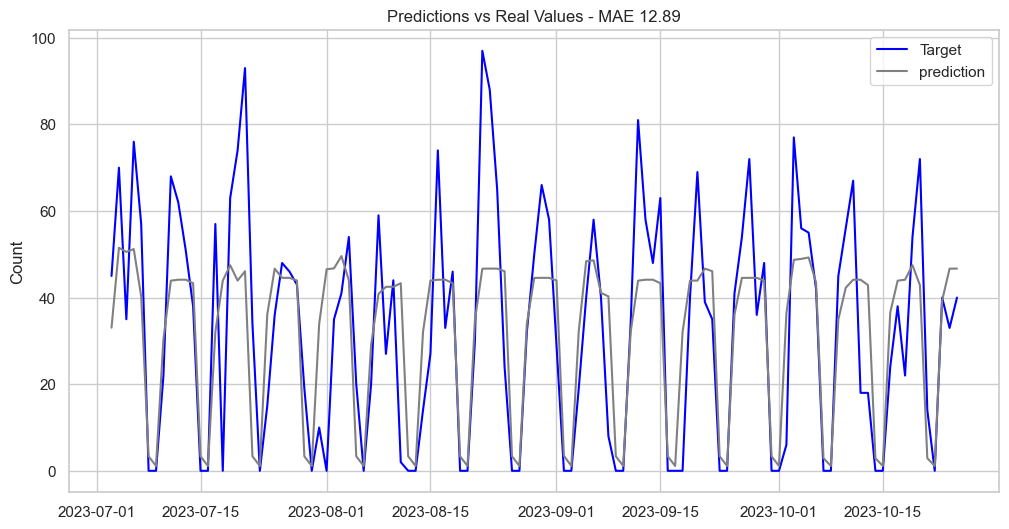

In [148]:
Model_mae['Light GBM']=LGBM_Tun_mae

# plot predictions vs expected
plt.figure(figsize=(12, 6))
plt.plot(Y_valid, label='Target', color='blue')
plt.plot(pd.DataFrame(Y_pred, index=data_val.index), label='prediction', color='grey')
plt.title(f'Predictions vs Real Values - MAE {LGBM_Tun_mae:.2f}')
plt.ylabel('Count')
plt.legend(loc='upper right')

# Show the plot
plt.show()

#### XGBoost

In [149]:
model = XGBRegressor()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_valid)
XGBR_mae = mean_absolute_error(Y_valid,Y_pred)
print(f'Light XGBR MAE: {XGBR_mae:.2f}')

Light XGBR MAE: 15.62


In [150]:
param_space = {
    'learning_rate': (0.01, 0.9, 'log-uniform'),
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
}

model = XGBRegressor()
opt = BayesSearchCV(model, param_space, n_iter=50, n_jobs=-1, cv=5, scoring='neg_mean_absolute_error')

opt.fit(X_train, Y_train)

best_params = opt.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = best_model.predict(X_valid)

# Evaluate the model
XGBR_Tun_mae = mean_absolute_error(Y_valid, Y_pred)
print(f'XGB regressor fine tuned Mean Absolute Error (MAE): {XGBR_Tun_mae:.2f}')

Best parameters: OrderedDict([('colsample_bytree', 0.9457548960007922), ('learning_rate', 0.02727428245074824), ('max_depth', 3), ('n_estimators', 167), ('subsample', 0.5)])
XGB regressor fine tuned Mean Absolute Error (MAE): 13.31


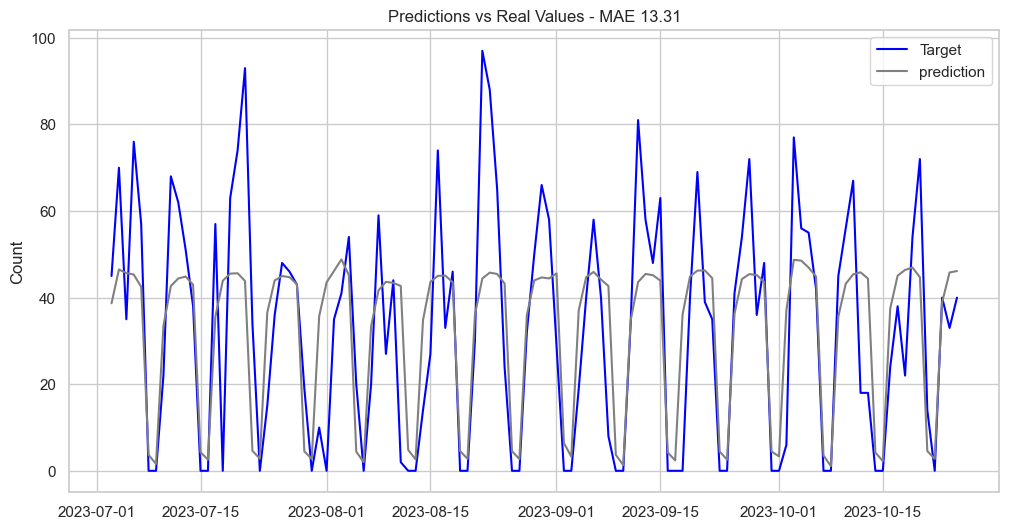

In [151]:
Model_mae['XGBoost']=XGBR_Tun_mae

# plot predictions vs expected
plt.figure(figsize=(12, 6))
plt.plot(Y_valid, label='Target', color='blue')
plt.plot(pd.DataFrame(Y_pred, index=data_val.index), label='prediction', color='grey')
plt.title(f'Predictions vs Real Values - MAE {XGBR_Tun_mae:.2f}')
plt.ylabel('Count')
plt.legend(loc='upper right')

# Show the plot
plt.show()

### LSTM tensorflow

In [152]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [153]:
class MyLSTMModel:
    def __init__(self, window_size, input_shape, layer_size):
        self.model = Sequential()
        self.model.add(LSTM(layer_size, activation='relu', input_shape=(window_size, input_shape), return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(layer_size, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mae')

    def summary(self):
        return self.model.summary()

    def fit(self, train_generator, val_generator, epochs):
        return self.model.fit_generator(train_generator, epochs=epochs, validation_data=val_generator)

    def evaluate(self, val_generator):
        return self.model.evaluate_generator(val_generator)
    
    def predict(self, val_generator):
        return self.model.predict_generator(val_generator)

Windows: 14 lags

In [154]:
# Window size (14 days)
window_size = 14

# Create time series generator
generator = TimeseriesGenerator(data_scaled, data_scaled[:, -1], length=window_size, batch_size=1)

# Split the data into training and validation sets
train_size = int(len(df) * 0.95)
train, val = data_scaled[0:train_size], data_scaled[train_size:]

# Create time series generators for training and validation
train_generator = TimeseriesGenerator(train, train[:, -1], length=window_size, batch_size=1)
val_generator = TimeseriesGenerator(val, val[:, -1], length=window_size, batch_size=1)

In [155]:
LSTM_model_1 = MyLSTMModel(window_size, df.shape[1], 25)
print(LSTM_model_1.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 14, 25)            3100      
                                                                 
 dropout_18 (Dropout)        (None, 14, 25)            0         
                                                                 
 lstm_19 (LSTM)              (None, 25)                5100      
                                                                 
 dropout_19 (Dropout)        (None, 25)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8226 (32.13 KB)
Trainable params: 8226 (32.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [156]:
logs = LSTM_model_1.fit(train_generator, val_generator, epochs=20)

Epoch 1/20
1796/1796 [==============================] - 6s 3ms/step - loss: 0.1558 - val_loss: 0.1456
Epoch 2/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.1466 - val_loss: 0.1472
Epoch 3/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.1335 - val_loss: 0.1043
Epoch 4/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.1080 - val_loss: 0.0899
Epoch 5/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.0980 - val_loss: 0.0806
Epoch 6/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.0947 - val_loss: 0.0790
Epoch 7/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.0904 - val_loss: 0.1051
Epoch 8/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.0894 - val_loss: 0.0779
Epoch 9/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.0877 - val_loss: 0.0782
Epoch 10/20
1796/1796 [==============================] - 5s 3ms/step - loss: 0.087

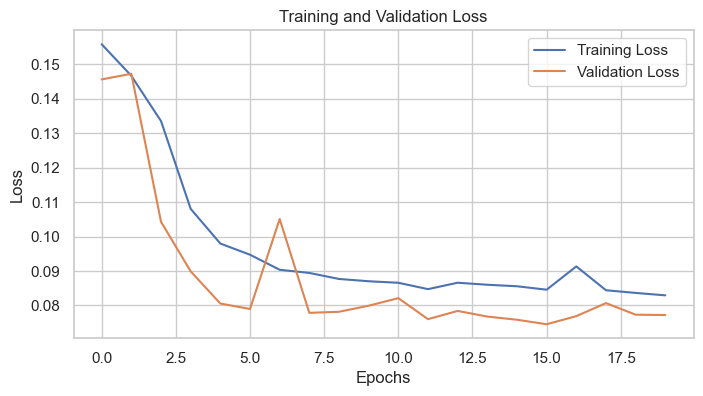

In [157]:
# Get the training and validation loss
training_loss = logs.history['loss']
validation_loss = logs.history['val_loss']

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [158]:
# Evaluate the model on the validation set
val_loss = LSTM_model_1.evaluate(val_generator)
print(f'Validation Loss: {val_loss:.2f}')

# Make predictions
predictions = LSTM_model_1.predict(val_generator)

Validation Loss: 0.08


In [159]:
features_and_predictions = np.concatenate((val[window_size:, :-1], predictions), axis=1)
features_inverted = scaler.inverse_transform(features_and_predictions)
pred_df = pd.DataFrame(features_inverted[:,-1:], index=df.index[train_size+14:])
LSTM_mae1 = mean_absolute_error(df.iloc[train_size+window_size:,-1:], pred_df)
print(f'LSTM mean absolute error: {LSTM_mae1:.2f}')

LSTM mean absolute error: 11.97


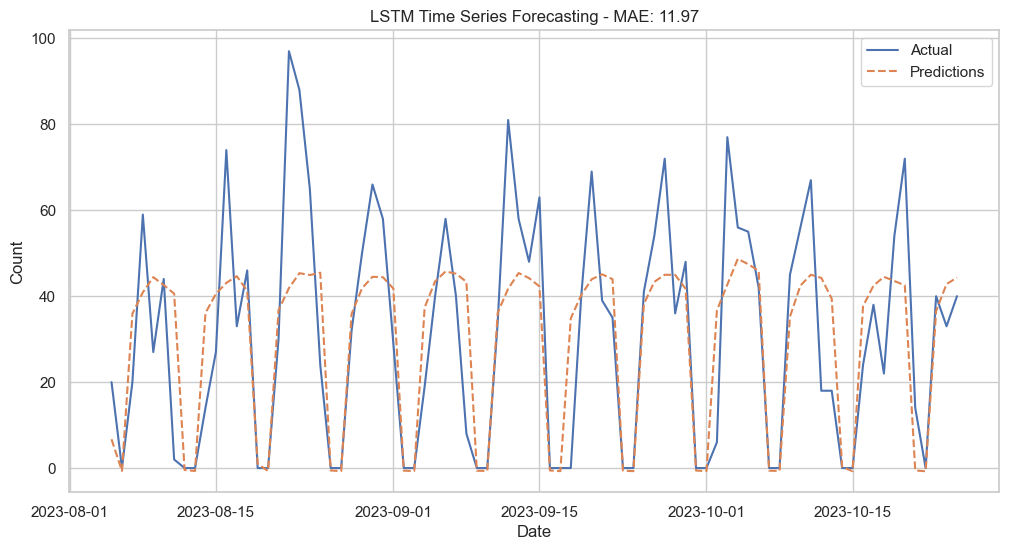

In [160]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[train_size+window_size:,-1:], label='Actual')
plt.plot(pred_df, label='Predictions', linestyle='dashed')
plt.title(f'LSTM Time Series Forecasting - MAE: {LSTM_mae1:.2f}')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()


Windows: 30 lags

In [161]:
window_size = 30

# Create time series generator
generator = TimeseriesGenerator(data_scaled, data_scaled[:, -1], length=window_size, batch_size=1)

# Split the data into training and validation sets
train_size = int(len(df) * 0.95)
train, val = data_scaled[0:train_size], data_scaled[train_size:]

# Create time series generators for training and validation
train_generator = TimeseriesGenerator(train, train[:, -1], length=window_size, batch_size=1)
val_generator = TimeseriesGenerator(val, val[:, -1], length=window_size, batch_size=1)

In [162]:
LSTM_model_2 = MyLSTMModel(window_size, df.shape[1], 25)
print(LSTM_model_2.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 30, 25)            3100      
                                                                 
 dropout_20 (Dropout)        (None, 30, 25)            0         
                                                                 
 lstm_21 (LSTM)              (None, 25)                5100      
                                                                 
 dropout_21 (Dropout)        (None, 25)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 26        
                                                                 
Total params: 8226 (32.13 KB)
Trainable params: 8226 (32.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [163]:
logs = LSTM_model_2.fit(train_generator, val_generator, epochs=20)

Epoch 1/20
1780/1780 [==============================] - 9s 5ms/step - loss: 0.1549 - val_loss: 0.1460
Epoch 2/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.1486 - val_loss: 0.1442
Epoch 3/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.1418 - val_loss: 0.1316
Epoch 4/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.1283 - val_loss: 0.1245
Epoch 5/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.1150 - val_loss: 0.0803
Epoch 6/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.1084 - val_loss: 0.0793
Epoch 7/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.0997 - val_loss: 0.0784
Epoch 8/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.0993 - val_loss: 0.0785
Epoch 9/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.0948 - val_loss: 0.0819
Epoch 10/20
1780/1780 [==============================] - 8s 5ms/step - loss: 0.096

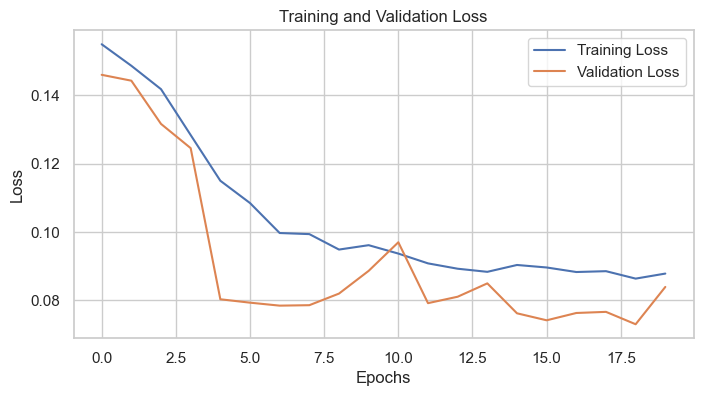

In [164]:
# Get the training and validation loss
training_loss = logs.history['loss']
validation_loss = logs.history['val_loss']

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [165]:
val_loss = LSTM_model_2.evaluate(val_generator)
print(f'Validation Loss: {val_loss:.2f}')

# Make predictions
predictions = LSTM_model_2.predict(val_generator)

Validation Loss: 0.08


In [166]:
features_and_predictions = np.concatenate((val[window_size:, :-1], predictions), axis=1)
features_inverted = scaler.inverse_transform(features_and_predictions)
pred_df = pd.DataFrame(features_inverted[:,-1:], index=df.index[train_size+window_size:])
LSTM_mae2 = mean_absolute_error(df.iloc[train_size+window_size:,-1:], pred_df)
print(f'LSTM mean absolute error: {LSTM_mae2:.2f}')

LSTM mean absolute error: 13.00


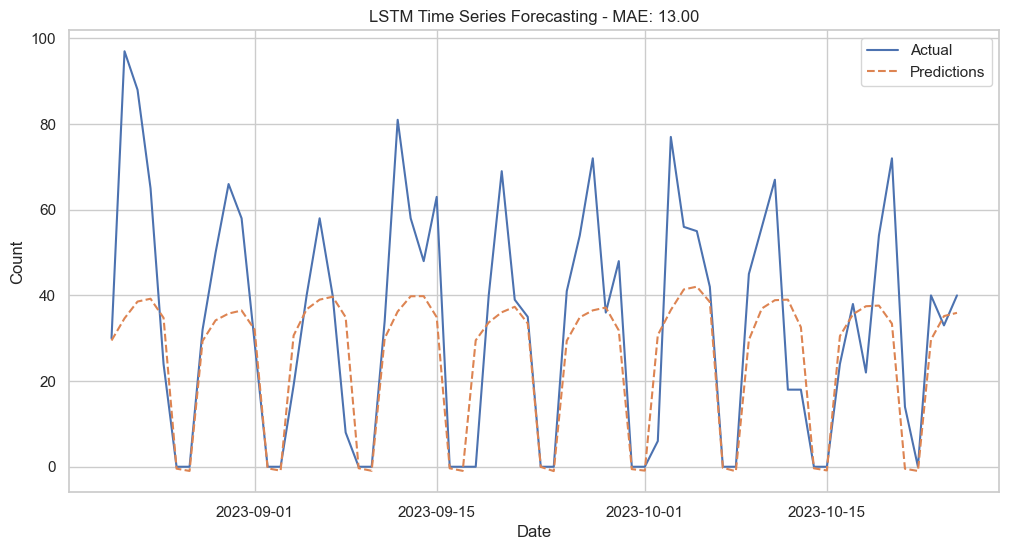

In [167]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[train_size+window_size:,-1:], label='Actual')
plt.plot(pred_df, label='Predictions', linestyle='dashed')
plt.title(f'LSTM Time Series Forecasting - MAE: {LSTM_mae2:.2f}')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

Windows: 7 lags

In [168]:
window_size = 7

# Create time series generator
generator = TimeseriesGenerator(data_scaled, data_scaled[:, -1], length=window_size, batch_size=1)

# Split the data into training and validation sets
train_size = int(len(df) * 0.95)
train, val = data_scaled[0:train_size], data_scaled[train_size:]

# Create time series generators for training and validation
train_generator = TimeseriesGenerator(train, train[:, -1], length=window_size, batch_size=1)
val_generator = TimeseriesGenerator(val, val[:, -1], length=window_size, batch_size=1)

In [169]:
LSTM_model_3 = MyLSTMModel(window_size, df.shape[1], 25)

In [170]:
logs = LSTM_model_3.fit(train_generator, val_generator, epochs=20)

Epoch 1/20
1803/1803 [==============================] - 4s 2ms/step - loss: 0.1238 - val_loss: 0.0942
Epoch 2/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0951 - val_loss: 0.1054
Epoch 3/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0924 - val_loss: 0.0866
Epoch 4/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0897 - val_loss: 0.0883
Epoch 5/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0903 - val_loss: 0.0892
Epoch 6/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0897 - val_loss: 0.0916
Epoch 7/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0866 - val_loss: 0.0829
Epoch 8/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0850 - val_loss: 0.0844
Epoch 9/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.0856 - val_loss: 0.0874
Epoch 10/20
1803/1803 [==============================] - 3s 2ms/step - loss: 0.085

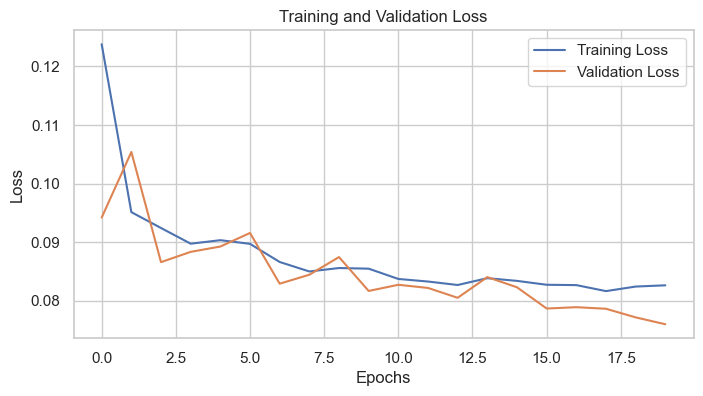

In [171]:
# Get the training and validation loss
training_loss = logs.history['loss']
validation_loss = logs.history['val_loss']

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [172]:
val_loss = LSTM_model_3.evaluate(val_generator)
print(f'Validation Loss: {val_loss:.2f}')

# Make predictions
predictions = LSTM_model_3.predict(val_generator)

Validation Loss: 0.08


In [173]:
features_and_predictions = np.concatenate((val[window_size:, :-1], predictions), axis=1)
features_inverted = scaler.inverse_transform(features_and_predictions)
pred_df = pd.DataFrame(features_inverted[:,-1:], index=df.index[train_size+window_size:])
LSTM_mae3 = mean_absolute_error(df.iloc[train_size+window_size:,-1:], pred_df)
print(f'LSTM mean absolute error: {LSTM_mae3:.2f}')

LSTM mean absolute error: 11.78


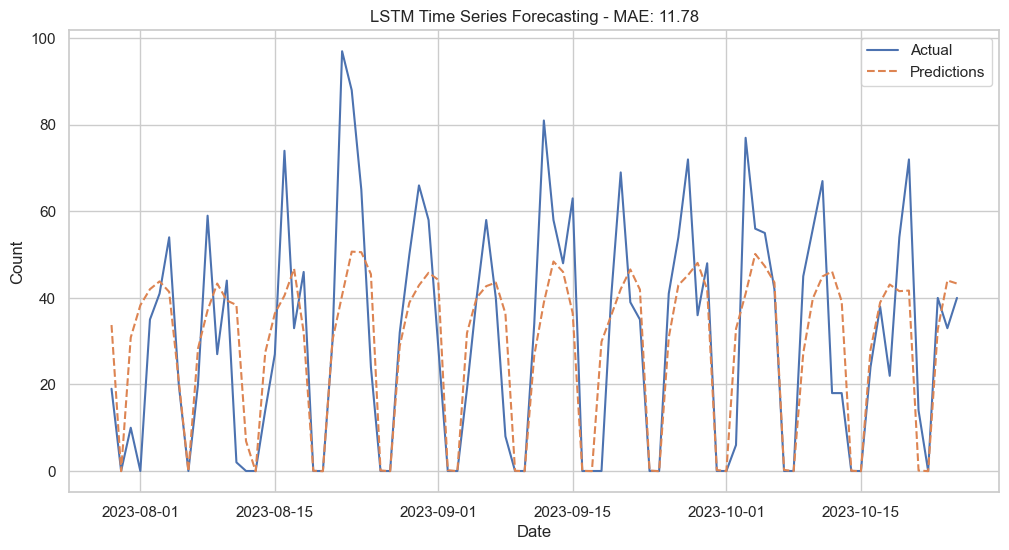

In [174]:
Model_mae['LSTM']=LSTM_mae1
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[train_size+window_size:,-1:], label='Actual')
plt.plot(pred_df, label='Predictions', linestyle='dashed')
plt.title(f'LSTM Time Series Forecasting - MAE: {LSTM_mae3:.2f}')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

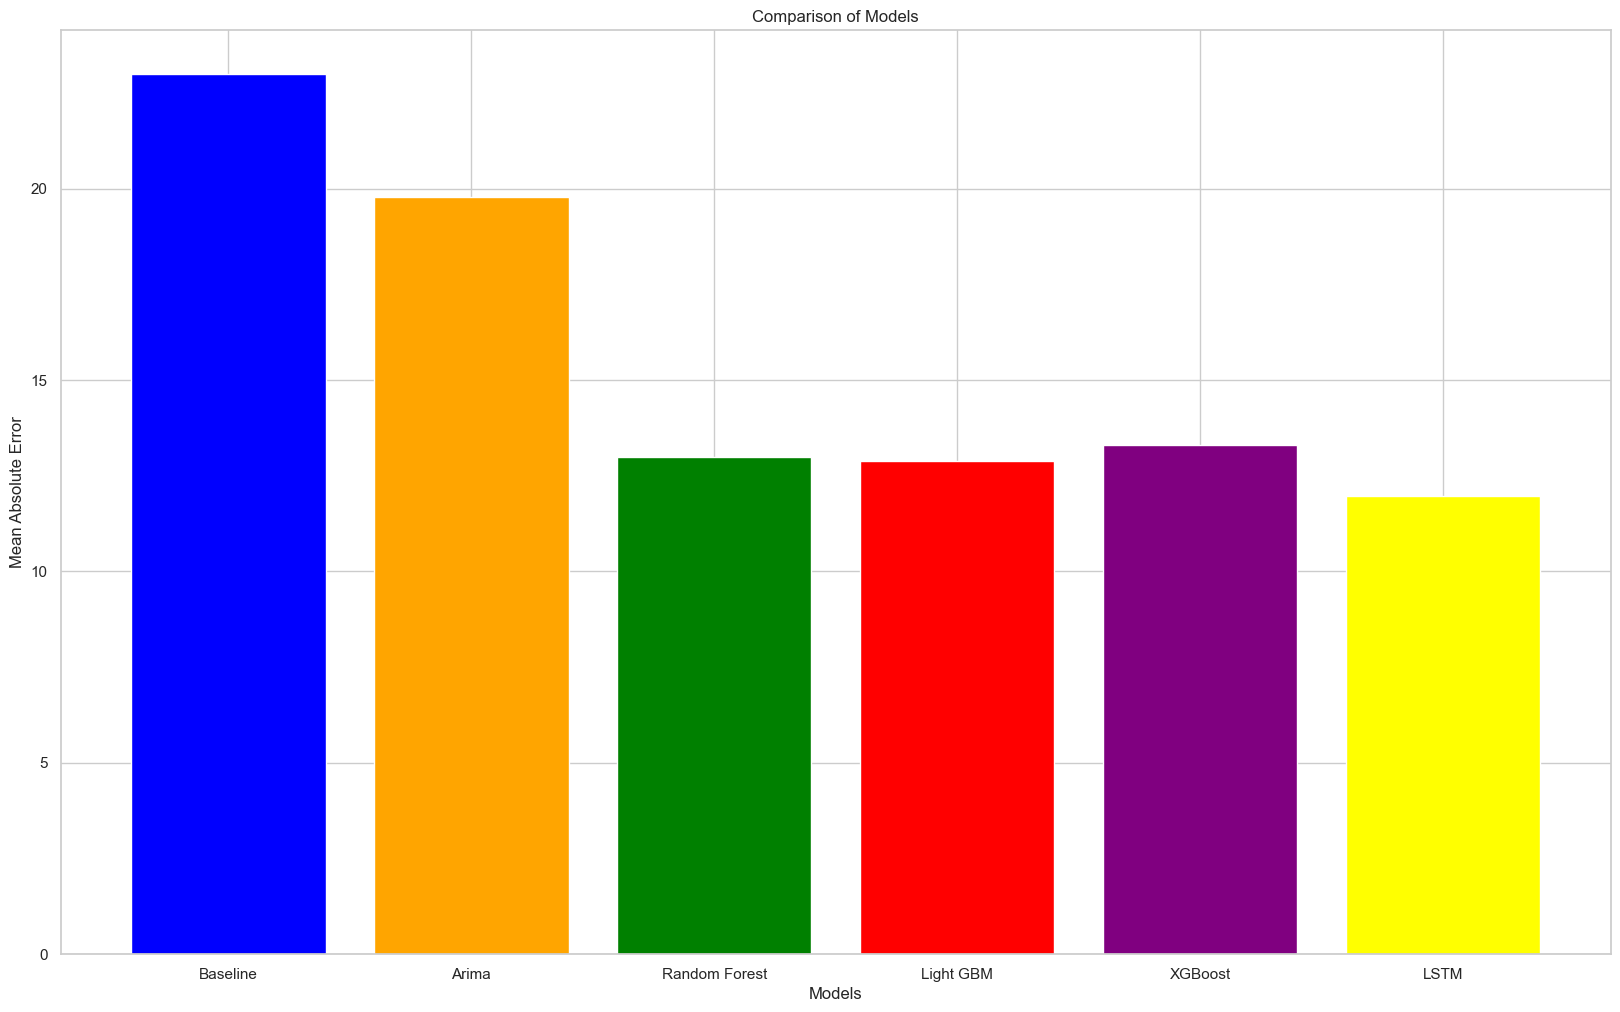

In [175]:
labels = list(Model_mae.keys())
values = list(Model_mae.values())

# Creating a bar plot
plt.bar(labels, values, color=['blue', 'orange', 'green', 'red', 'purple','yellow'])
plt.title('Comparison of Models')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.show()